In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
file_path = "processed_event_features.h5"
with h5py.File(file_path, 'r') as f:
    event_id = f["event_id"][:]
    nhits = f["nhits"][:]
    target = f["target"][:]
    sum_energy = f["sum_energy_per_layer"][:]
    E1_E7 = f["E1_over_E7"][:]
    E7_E19 = f["E7_over_E19"][:]

num_events, num_layers = sum_energy.shape
print(num_events,num_layers)
# Build DataFrame
df = pd.DataFrame({
    "event_id": event_id,
    "nhits": nhits,
    "target": target
})

# Add per-layer features
for l in range(num_layers):
    df[f"sumE_L{l}"] = sum_energy[:, l]
    df[f"E1_E7_L{l}"] = E1_E7[:, l]
    df[f"E7_E19_L{l}"] = E7_E19[:, l]

50000 28


In [3]:
from sklearn.preprocessing import StandardScaler

# Drop unused columns
X = df.drop(columns=['event_id', 'target'])
y = df['target']

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train size: 40000
Test size: 10000


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer: regression → no activation
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


2025-07-09 10:10:17.728573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-09 10:10:24.214216: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11008     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,329
Trainable params: 19,329
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=256,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
                    ],
                    verbose=1)


Epoch 1/100
125/125 [==============================] - 7s 38ms/step - loss: 16327.2480 - mae: 96.0764 - val_loss: 1372.1652 - val_mae: 28.3860
Epoch 2/100
125/125 [==============================] - 3s 26ms/step - loss: 1045.5686 - mae: 24.6048 - val_loss: 821.8473 - val_mae: 21.7664
Epoch 3/100
125/125 [==============================] - 2s 16ms/step - loss: 759.6198 - mae: 20.8786 - val_loss: 660.2104 - val_mae: 19.4672
Epoch 4/100
125/125 [==============================] - 2s 18ms/step - loss: 620.6082 - mae: 18.8404 - val_loss: 550.0001 - val_mae: 17.6788
Epoch 5/100
125/125 [==============================] - 3s 27ms/step - loss: 519.1157 - mae: 17.2032 - val_loss: 467.9449 - val_mae: 16.2934
Epoch 6/100
125/125 [==============================] - 3s 24ms/step - loss: 436.2496 - mae: 15.7858 - val_loss: 401.1566 - val_mae: 15.1054
Epoch 7/100
125/125 [==============================] - 2s 19ms/step - loss: 362.5928 - mae: 14.4605 - val_loss: 331.1046 - val_mae: 13.7759
Epoch 8/100
125/

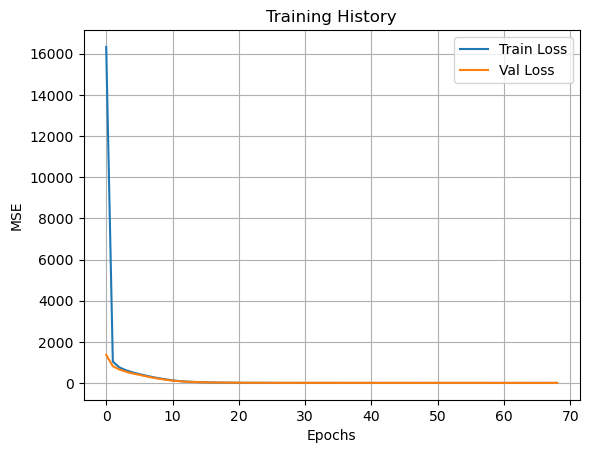

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Training History")
plt.grid(True)
plt.savefig('training_history.png')
plt.show()


In [7]:
#Model evaluation
y_pred = model.predict(X_test_scaled).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mre = np.mean(np.abs((y_pred - y_test) / y_test))

print(f"DNN MAE: {mae:.4f} GeV")
print(f"DNN MSE: {mse:.4f} GeV²")
print(f"DNN MRE: {mre:.4f}")


313/313 [==============================] - 2s 5ms/step
DNN MAE: 2.4485 GeV
DNN MSE: 10.9571 GeV²
DNN MRE: 0.0215


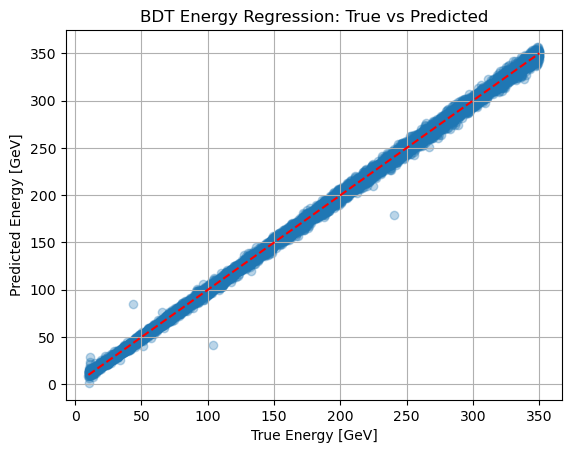

In [8]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True Energy [GeV]")
plt.ylabel("Predicted Energy [GeV]")
plt.title("BDT Energy Regression: True vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.savefig('dnn_true_vs_predicted_energy.png')
plt.show()


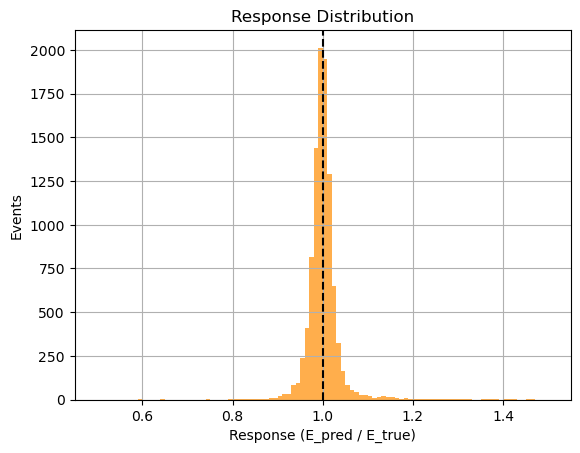

In [9]:
response = y_pred / y_test

plt.figure()
plt.hist(response, bins=100, range=(0.5, 1.5), color='darkorange', alpha=0.7)
plt.axvline(1.0, color='k', linestyle='--')
plt.xlabel("Response (E_pred / E_true)")
plt.ylabel("Events")
plt.title("Response Distribution")
plt.grid(True)
plt.savefig('response_distribution.png')
plt.show()


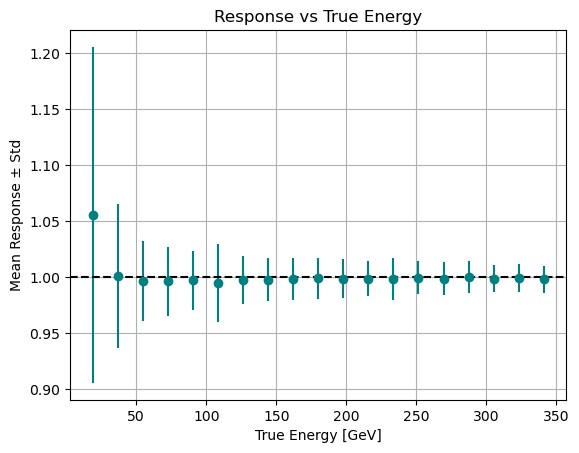

In [10]:
import numpy as np

# Bin true energy
bins = np.linspace(y_test.min(), y_test.max(), 20)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
response = y_pred / y_test

mean_response = []
std_response = []

for i in range(len(bins) - 1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    resp_bin = response[mask]
    if len(resp_bin) > 0:
        mean_response.append(np.mean(resp_bin))
        std_response.append(np.std(resp_bin))
    else:
        mean_response.append(np.nan)
        std_response.append(np.nan)

# Plot
plt.errorbar(bin_centers, mean_response, yerr=std_response, fmt='o', color='teal')
plt.axhline(1.0, color='k', linestyle='--')
plt.xlabel("True Energy [GeV]")
plt.ylabel("Mean Response ± Std")
plt.title("Response vs True Energy")
plt.grid(True)
plt.savefig('mean_response_vs_true_energy.png')
plt.show()


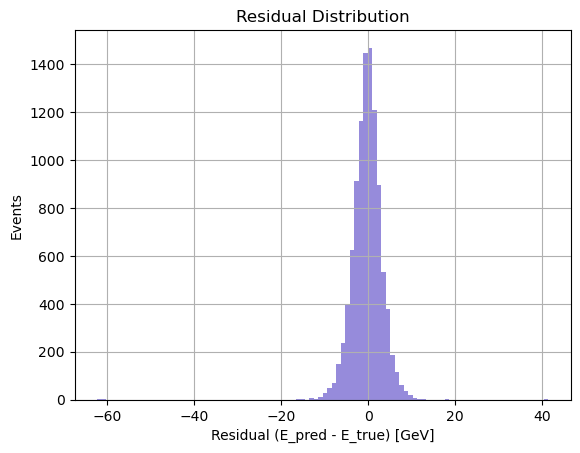

In [11]:
residual = y_pred - y_test

plt.figure()
plt.hist(residual, bins=100, color='slateblue', alpha=0.7)
plt.xlabel("Residual (E_pred - E_true) [GeV]")
plt.ylabel("Events")
plt.title("Residual Distribution")
plt.grid(True)
plt.savefig('residual_distribution.png')
plt.show()


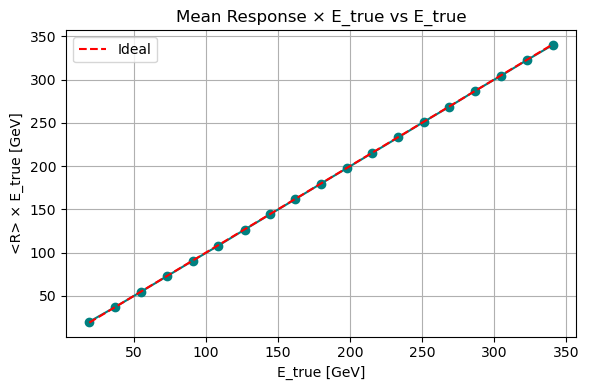

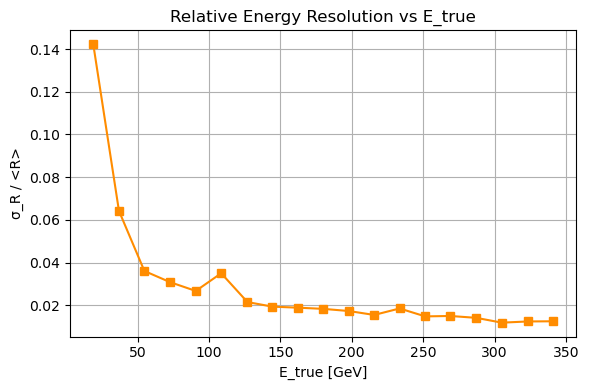

In [12]:
import numpy as np
import matplotlib.pyplot as plt

R = y_pred / y_test

# Bin true energy
bins = np.linspace(y_test.min(), y_test.max(), 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

mean_response = []
sigma_response = []
mean_energy = []

for i in range(len(bins) - 1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    R_bin = R[mask]
    E_bin = y_test[mask]
    
    if len(R_bin) > 0:
        R_mean = np.mean(R_bin)
        sigma = np.std(R_bin)
        
        mean_response.append(R_mean)
        sigma_response.append(sigma / R_mean)  # σ_R / ⟨R⟩
        mean_energy.append(np.mean(E_bin))
    else:
        mean_response.append(np.nan)
        sigma_response.append(np.nan)
        mean_energy.append(np.nan)

# Plot 1: <R> * E_true vs E_true
plt.figure(figsize=(6, 4))
plt.plot(mean_energy, np.array(mean_response) * np.array(mean_energy), marker='o', color='teal')
plt.plot(mean_energy, mean_energy, 'r--', label="Ideal")
plt.xlabel("E_true [GeV]")
plt.ylabel("<R> × E_true [GeV]")
plt.title("Mean Response × E_true vs E_true")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('mean_response_vs_true_energy_binwise.png')
plt.show()

# Plot 2: σ_R / <R> vs E_true
plt.figure(figsize=(6, 4))
plt.plot(mean_energy, sigma_response, marker='s', color='darkorange')
plt.xlabel("E_true [GeV]")
plt.ylabel("σ_R / <R>")
plt.title("Relative Energy Resolution vs E_true")
plt.grid(True)
plt.tight_layout()
plt.savefig('relative_energy_resolution_vs_true_energy.png')
plt.show()


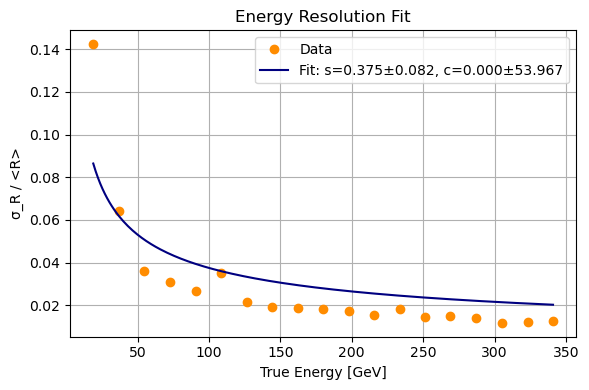

In [13]:
from scipy.optimize import curve_fit
# Stochastic formula
def resolution_func(E, s, c):
    return np.sqrt((s / np.sqrt(E))**2 + c**2)

# Clean the data
E_vals = np.array(mean_energy)
res_vals = np.array(sigma_response)

mask = ~np.isnan(E_vals) & ~np.isnan(res_vals)
E_fit = E_vals[mask]
res_fit = res_vals[mask]

# Fit using curve_fit
popt, pcov = curve_fit(resolution_func, E_fit, res_fit, p0=[0.2, 0.01])
s_fit, c_fit = popt
s_err, c_err = np.sqrt(np.diag(pcov))

E_plot = np.linspace(min(E_fit), max(E_fit), 200)
fit_vals = resolution_func(E_plot, s_fit, c_fit)

plt.figure(figsize=(6, 4))
plt.plot(E_fit, res_fit, 'o', label="Data", color='darkorange')
plt.plot(E_plot, fit_vals, '-', label=f"Fit: s={s_fit:.3f}±{s_err:.3f}, c={c_fit:.3f}±{c_err:.3f}", color='navy')
plt.xlabel("True Energy [GeV]")
plt.ylabel("σ_R / <R>")
plt.title("Energy Resolution Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('energy_resolution_fit.png')
plt.show()


In [14]:
from sklearn.inspection import permutation_importance

# Use the correct number of layers and feature name format
layer_ids = [f"L{l}" for l in range(num_layers)]
feature_names = [f"sumE_{l}" for l in layer_ids] + \
                [f"E1_E7_{l}" for l in layer_ids] + \
                [f"E7_E19_{l}" for l in layer_ids]

# model must support predict()
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)

importances = result.importances_mean
stds = result.importances_std

# Plot
sorted_idx = np.argsort(importances)[::-1]
sorted_names = np.array(feature_names)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:20][::-1], importances[sorted_idx][:20][::-1], xerr=stds[sorted_idx][:20][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 20 DNN Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.savefig('dnn_feature_importances.png')
plt.show()

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7de12ad23d10> does not.